In [38]:
from pathlib import Path
from pyproj import CRS, Transformer

import pandas as pd
import geopandas as gpd
import shapely.geometry
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# reading input scenario

urbansim_source_dir = "../beam_root/production/sfbay/urbansim"

persons = pd.read_csv(f"{urbansim_source_dir}/persons.csv.gz")
households = pd.read_csv(f"{urbansim_source_dir}/households.csv.gz")
plans = pd.read_csv(f"{urbansim_source_dir}/plans.csv.gz")
blocks = pd.read_csv(f"{urbansim_source_dir}/blocks.csv.gz")

print(f"Number of persons: {persons.shape[0]}, number of households: {households.shape[0]}, number of unique persons in plans: {plans['person_id'].nunique()}")

Number of persons: 721814
Number of households: 275783


In [4]:
# getting activities

activities = plans[plans['ActivityElement'] == 'activity'][['person_id','ActivityType','x','y']]
display(activities.head(2))

# sanity check
display(activities.isna().sum().to_frame())

,person_id,ActivityType,x,y
0,4.0,Home,-122.227937,37.854097
2,4.0,othdiscr,-122.242641,37.793755


,0
person_id,0
ActivityType,0
x,0
y,0


In [29]:
# reading the shp file and converting it to activities `x` and `y` CRS

shape_file_path = "../local_files/vta-filtering-plans/MTC-1454-TAZ.zip"
selected_districts = set([8, 9, 10, 11, 12, 13, 14])

# reading the shape file
shp_df_wrong_crs = gpd.read_file(shape_file_path)

# converting the shapefile to required CRS
shp_df_full = shp_df_wrong_crs.to_crs(4326)

shp_df = shp_df_full[shp_df_full['SUPERD'].isin(selected_districts)]
display(shp_df.head(2))
print(f"Selected districts has: {len(shp_df)} rows, full shape file has {len(shp_df_full)} rows.")

,OBJECTID,SUPERD,TAZ1454,Shape__Are,Shape__Len,geometry
794,795,11,547,1.924186e+06,6068.548124,"POLYGON ((-121.89867 37.35264, -121.90027 37.3..."
795,796,11,542,1.018191e+06,4120.214275,"POLYGON ((-121.92197 37.34604, -121.91957 37.3..."


Selected districts has: 368 rows, full shape file has 1454 rows.


In [30]:
# getting CRS of the shp file

shp_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [31]:
# saving filtered-out shapefile dataframe to files (by folder path)
shp_df.to_file("../local_files/vta-filtering-plans/MTC-1454-TAZ-selected-districts")

In [32]:
# getting geo_activities dataframe with CRS of the SHP file

points = gpd.points_from_xy(activities["x"], activities["y"], crs="EPSG:4326")
geo_activities = gpd.GeoDataFrame(activities, geometry=points)[['person_id','ActivityType', 'geometry']]
geo_activities.head(2)

,person_id,ActivityType,geometry
0,4.0,Home,POINT (-122.22794 37.85410)
2,4.0,othdiscr,POINT (-122.24264 37.79376)


In [24]:
# saving activities locations to shape file

geo_activities.to_file(filename="../local_files/vta-filtering-plans/activities_shape.zip", driver='ESRI Shapefile')

/tmp/ipykernel_8752/4031393213.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  geo_activities.to_file(filename="../local_files/vta-filtering-plans/activities_shape.zip", driver='ESRI Shapefile')


In [33]:
# getting activities within shape file

# `predicate` must be one of {'covers', 'within', 'contains', 'contains_properly', 'covered_by', 'intersects', 'crosses', 'overlaps', None, 'touches'}
geo_activities_joined = geo_activities.sjoin(shp_df, predicate="within")
geo_activities_joined.head(2)

,person_id,ActivityType,geometry,index_right,OBJECTID,SUPERD,TAZ1454,Shape__Are,Shape__Len
38,115.0,school,POINT (-121.85667 37.40081),912,913,12,626,1.437880e+06,5875.356905
174,172.0,school,POINT (-121.85347 37.40087),912,913,12,626,1.437880e+06,5875.356905


In [34]:
# calculating how many persons there are in original activities and with activities within shape file

persons_joined = geo_activities_joined['person_id'].nunique()
persons_original = activities['person_id'].nunique()

persons_joined, persons_original, f"the delta is {persons_joined - persons_original}"

(188268, 644216, 'the delta is -455948')

In [36]:
# getting selected persons IDs

persons_ids_within_shape = set(geo_activities_joined['person_id'].unique())
print(f"there are {len(persons_ids_within_shape)} persons with activities within the shape file area")

there are 188268 persons with activities within the shape file area


In [47]:
# downsampling scenario based on selected persons
# usually we take persons ids, then households, then take all persons within households, but this time I took only selected persons 

selected_persons_df = persons[persons['person_id'].isin(persons_ids_within_shape)]
print(f"there are {len(selected_persons_df)} selected persons (out of {len(persons)})")

selected_households_ids = set(selected_persons_df['household_id'].unique())
selected_households_df = households[households['household_id'].isin(selected_households_ids)]
print(f"there are {len(selected_households_df)} selected households (out of {len(households)})")

selected_plans_df = plans[plans['person_id'].isin(persons_ids_within_shape)]
print(f"there are {len(selected_plans_df)} selected plans (out of {len(plans)})")

selected_block_ids = set(selected_households_df['block_id'])
selected_blocks_df = blocks[blocks['block_id'].isin(selected_block_ids)]
print(f"there are {len(selected_blocks_df)} selected blocks (out of {len(blocks)})")

there are 188268 selected persons (out of 721814)
there are 82420 selected households (out of 275783)
there are 1705784 selected plans (out of 5667836)
there are 21850 selected blocks (out of 109228)


<AxesSubplot: >

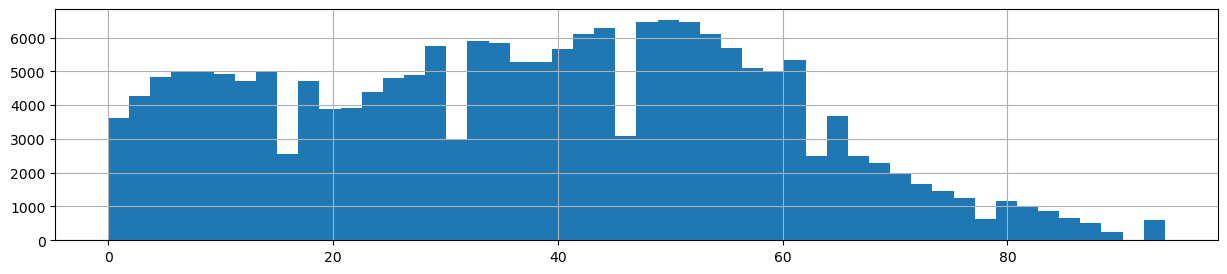

In [50]:
# sanity check

selected_persons_df['age'].hist(bins=50, figsize=(15,3))

In [51]:
# saving downsampled scenario to output dir

out_dir = 'sampled_scenario'

Path(out_dir).mkdir(parents=True, exist_ok=True)

selected_persons_df.to_csv(f'{out_dir}/persons.csv.gz', index=False, compression='gzip')
selected_households_df.to_csv(f'{out_dir}/households.csv.gz', index=False, compression='gzip')
selected_plans_df.to_csv(f'{out_dir}/plans.csv.gz', index=False, compression='gzip')
selected_blocks_df.to_csv(f'{out_dir}/blocks.csv.gz', index=False, compression='gzip')